In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt

In [2]:
# Camera calibration

# get the path to the calibration images
images = glob.glob('camera_cal/*.jpg')

In [3]:
# decide chessboard dimensions
nx = 9
ny = 6

In [4]:
# loop through all the images to get image points (the coordinates of the corners)

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


for image in images:
    
    img = cv2.imread(image)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


Text(0.5, 1.0, 'Undistorted Image')

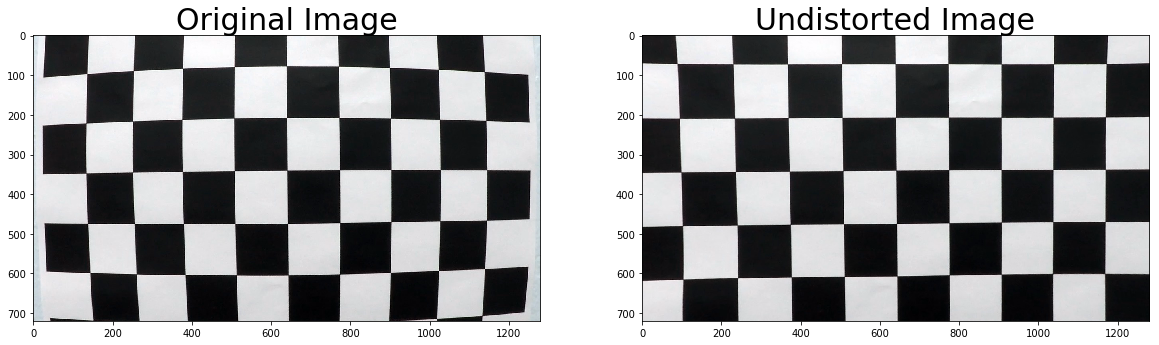

In [5]:

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',undist)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
#plt.imsave("output_images/undistort.jpg", undist)

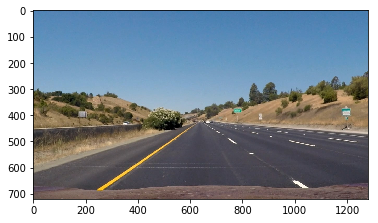

In [40]:
# read in an image to perform the test on setting threshold
#image = cv2.imread('captures/frame820.jpg')
#792 820 788
image = cv2.imread('test_images/straight_lines1.jpg')
image_copy = image.copy()

# show the original image
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)
plt.imshow(image_copy)

In [7]:
image.shape

(720, 1280, 3)

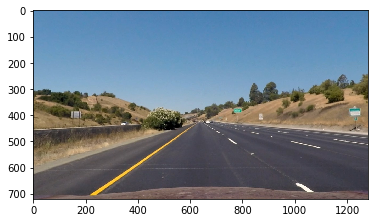

In [42]:
# undistort the image
undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
#undist_image = cv2.cvtColor(undist_image, cv2.COLOR_RGB2BGR)
plt.imshow(undist_image)
#plt.imsave("output_images/undistorted_test5.jpg", undist_image)
#792 820 788

In [43]:
gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

In [10]:
'''
image_LAB = cv2.cvtColor(undist_image, cv2.COLOR_BGR2LAB)
L_channel = hls[:,:,0]
A_channel = hls[:,:,1]
B_channel = hls[:,:,2]
f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(20,10))
axis1.imshow(L_channel)
axis1.set_title('L Channel', fontsize=20)
axis2.imshow(A_channel)
axis2.set_title('A Channel', fontsize=20)
axis3.imshow(B_channel)
axis3.set_title('B Channel', fontsize=20)
'''

"\nimage_LAB = cv2.cvtColor(undist_image, cv2.COLOR_BGR2LAB)\nL_channel = hls[:,:,0]\nA_channel = hls[:,:,1]\nB_channel = hls[:,:,2]\nf, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(20,10))\naxis1.imshow(L_channel)\naxis1.set_title('L Channel', fontsize=20)\naxis2.imshow(A_channel)\naxis2.set_title('A Channel', fontsize=20)\naxis3.imshow(B_channel)\naxis3.set_title('B Channel', fontsize=20)\n"

In [11]:
'''
thresh = (140, 170)
b_binary = np.zeros_like(B_channel)
b_binary[(B_channel > thresh[0]) & (B_channel <= thresh[1])] = 1
plt.imshow(b_binary)
'''

'\nthresh = (140, 170)\nb_binary = np.zeros_like(B_channel)\nb_binary[(B_channel > thresh[0]) & (B_channel <= thresh[1])] = 1\nplt.imshow(b_binary)\n'

Text(0.5, 1.0, 'S Channel')

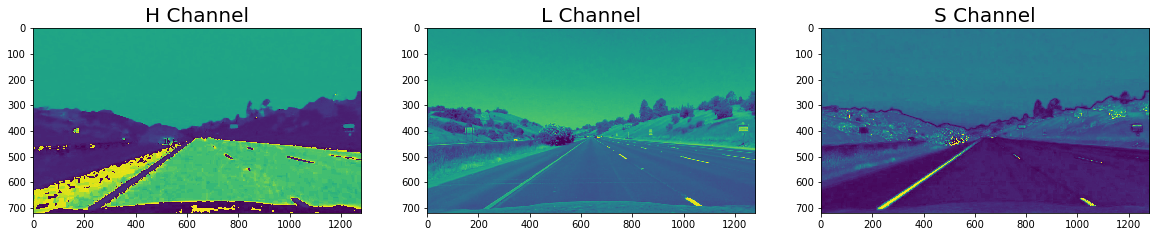

In [44]:
# convert image to HLS color space to check which one shows the lanes best

hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
H_channel = hls[:,:,0]
L_channel = hls[:,:,1]
S_channel = hls[:,:,2]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H_channel)
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(L_channel)
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(S_channel)
ax3.set_title('S Channel', fontsize=20)

# obviously, the S Channel picks up the lanes best

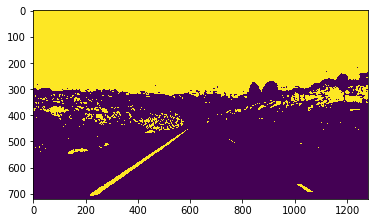

In [45]:
thresh = (90, 255)
s_binary = np.zeros_like(S_channel)
s_binary[(S_channel > thresh[0]) & (S_channel <= thresh[1])] = 1
plt.imshow(s_binary)

In [46]:
# this pipeline processed the image by applying sobelx and choosing HLS's S channel to highlight the lanes, 
# the pipeline will produce a binary image
#s_thresh=(170, 255), sx_thresh=(100, 200)
def binary_pipeline(image, s_thresh=(170, 255), sx_thresh=(0, 255)):
    image = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # apply Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

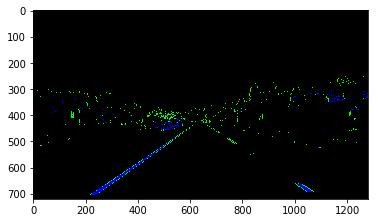

In [47]:
edited_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(50, 200))
plt.imshow(edited_image)
#plt.imsave("output_images/binary_image.jpg", edited_image)

In [48]:
# estimated begining point height, and ending point height
beg_point = 450
end_point = 720

In [49]:
# draw the source points
# functions borrowed from project 1
# region of interest
# draw
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    
    # calculate each line's slope
    slopes = []
    i = 0
    for line in lines:
        slopes.append((line[0][3] - line[0][1]) / (line[0][2] - line[0][0]))
        i += 1
    
    # group lines by +ve and -ve slopes, +ve is left, -ve is right
    left_lines = []
    right_lines = []
    left_slope_sum = 0
    right_slope_sum = 0
    
    j = 0
    for slope in slopes:
        if slope > 0:
            left_lines.append(lines[j])
            left_slope_sum += slope
        else:
            right_lines.append(lines[j])
            right_slope_sum += slope
        j += 1
    
    # averaging the slopes
    left_slope_avg = left_slope_sum/len(left_lines)
    right_slope_avg = right_slope_sum/len(right_lines)
    # get a random pt
    
    left_point_index = np.random.randint(len(left_lines))
    left_line = left_lines[left_point_index]
    left_point = [left_line[0][0], left_line[0][1]]
    
    if left_slope_avg < 50 and left_slope_avg > -50:
        upper_left_x = int((beg_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        lower_left_x = int((end_point - left_point[1] + left_slope_avg * left_point[0]) / left_slope_avg)
        img = cv2.line(img, (upper_left_x, beg_point), (lower_left_x, end_point), color, thickness)
        
    right_point_index = np.random.randint(len(right_lines))
    right_line = right_lines[right_point_index]
    right_point = [right_line[0][0], right_line[0][1]]
    
    if right_slope_avg < 50 and right_slope_avg > -50:
        upper_right_x = int((beg_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        lower_right_x = int((end_point - right_point[1] + right_slope_avg * right_point[0]) / right_slope_avg )
        img = cv2.line(img, (upper_right_x, beg_point), (lower_right_x, end_point), color, thickness)
        
    return right_slope_avg, left_slope_avg, right_point, left_point
    
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    right_slope, left_slope, right_point, left_point = draw_lines(line_img, lines)
    
    return line_img, right_slope, left_slope, right_point, left_point

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

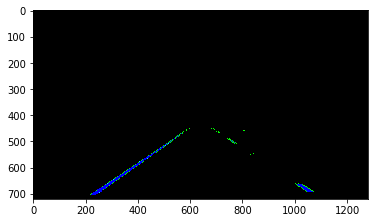

In [50]:
imshape = edited_image.shape
vertices = np.array([[(0,imshape[0]),(570, 450), (800, 450), (imshape[1],imshape[0])]], dtype=np.int32)

# mark the region of interest (the lanes area)
masked_edges = region_of_interest(edited_image, vertices)
plt.imshow(masked_edges)

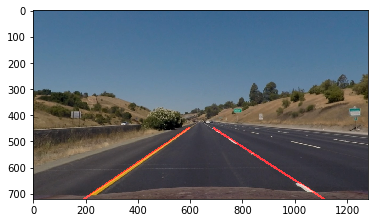

In [51]:
# run Hough transformation and draw the lanes in red
masked = cv2.cvtColor(masked_edges, cv2.COLOR_BGR2GRAY)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100 #minimum number of pixels making up a line
max_line_gap = 160   # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
line_image, right_slope, left_slope, right_point, left_point = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap)

# Draw the lines on the edge image
lines_edges = weighted_img(line_image, undist_image)
plt.imshow(lines_edges)
plt.imsave("output_images/after_hough.jpg", lines_edges)

In [52]:
# get source points and dest points 
# calculating source points coordinate
print(left_point)
print(right_point)
print(left_slope)
print(right_slope)
# source point 1
y1 = beg_point
x1 = int((y1 - left_point[1] + left_slope * left_point[0]) / left_slope)
#print(x1)
# source point 2
y2 = beg_point
x2 = int((y2 - right_point[1] + right_slope * right_point[0]) / right_slope)
#print(x2)
# source point 3
y3 = end_point
x3 = int((y3 - left_point[1] + left_slope * left_point[0]) / left_slope)
#print(x3)
# source point 4
y4 = end_point
x4 = int((y4 - right_point[1] + right_slope * right_point[0]) / right_slope)
#print(x4)
src_points = [[x2, y2], [x1, y1], [x3, y3], [x4, y4]]
src_points = np.asarray(src_points, dtype='float32')
print(src_points)

[728, 474]
[220, 703]
0.6376549315472614
-0.6744838498015413
[[ 595.  450.]
 [ 690.  450.]
 [1113.  720.]
 [ 194.  720.]]


In [53]:
# destination points, it should be a rectangle

dest_points = []
dest_points.append([280, 0])
dest_points.append([1000, 0])

dest_points.append([1000, 720])
dest_points.append([280, 720])
dest_points = np.asarray(dest_points, dtype='float32')


In [54]:
# apply a "bird-eye-view" perspective transform

M = cv2.getPerspectiveTransform(src_points, dest_points)

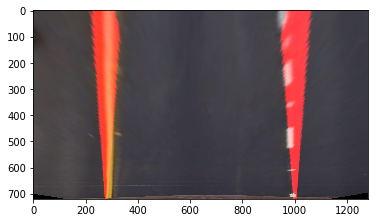

In [55]:

img_size = gray.shape[::-1]
#lines_edges
warped_img = cv2.warpPerspective(lines_edges, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped_img)
plt.imsave("output_images/warped_imaged.jpg", warped_img)

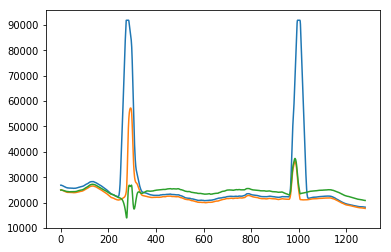

In [56]:
# Detect lane pixels and fit to find the lane boundary.

# Plot histogram

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram



# Create histogram of image binary activations
histogram = hist(warped_img)

# Visualize the resulting histogram
plt.plot(histogram)

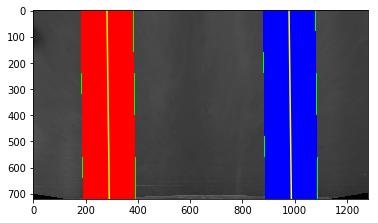

In [57]:
# this function will draw 2 histograms represent the lane lines, 
# draw sliding windows to cover the lanes and identify nonzero pixels
# the following fit_polynomial function will fit a second order polynomial to fit the lane pixels

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

gray_scale = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale)

plt.imshow(out_img)

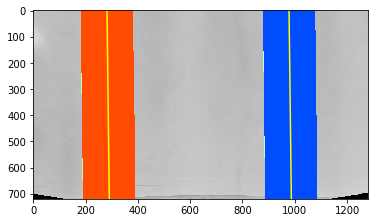

In [58]:
# this cell's functions are used to search the lane pixels around a margin,
# using previous frame's poly fit

# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty, left_fit, right_fit):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, left_fit, right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    # Fit new polynomials to x,y in world space
    
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty


result, left_fitx, right_fitx, ploty = search_around_poly(gray_scale, left_fit, right_fit)

# View output
plt.imshow(result)

In [59]:
# Determine the curvature of the lane in pixels
# calculate the radius of the curvature of the fit

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

1.7518044003194964e+16 5193729947426102.0


In [60]:
# Measure the real curvature, in meters

def measure_curvature_real(left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 22/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # move to center
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, left_fit_cr, right_fit_cr


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

2527083957021640.0 m 1125208375897332.9 m


In [61]:
# vehicle position with respect to center

def measure_vehicle_position(left_fitx, right_fitx):
    
    midpoint_lane = (right_fitx[719] + left_fitx[719]) / 2
    midpoint_image = 1280/2
    xm_per_pix = 3.7/700
    offset_pixels = np.abs(midpoint_image - midpoint_lane)
    offset = offset_pixels * xm_per_pix
    
    return offset

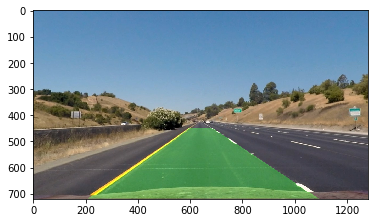

In [62]:
# change perspective back to the road

# Create an image to draw the lines on
warp_zero = np.zeros_like(gray_scale).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dest_points, src_points)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.imsave("output_images/result.jpg", result)

In [35]:
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
adjusted_result = None
adjusted_offset = 0
adjusted_left_cr = None
adjusted_right_cr = None
adjusted_left_curverad = 0
adjusted_right_curverad = 0
prev_green_area = []

In [36]:
# This is the main pipeline that combine the procedures above to process frame one by one
# it undists an image, turn it to gray and produce a binary image to highlight the lanes
# Then, it changes the lanes area to bird-eye-view and fit a polynomial to nonzero pixels.
# It changes the image back to original perspective with green area of the lane highlighted.
# It also calculates the lane radius of curvatures and vehicle position with respect to center
# of the image.  Finally, it display the information on the image and return the image.

def process_image(image):
    
    global left_fit
    global right_fit
    global ploty
    global adjusted_result
    global adjusted_offset
    global adjusted_left_cr
    global adjusted_right_cr
    global adjusted_left_curverad
    global adjusted_right_curverad
    global prev_green_area
    
    # get basic info of the image, and make a copy
    ysize = image.shape[0]
    xsize = image.shape[1]
    image_copy = np.copy(image)
    #image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)
    
    
    # undistort image
    undist_image = cv2.undistort(image_copy, mtx, dist, None, mtx)
    # turn image to gray scale
    gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
    # apply color analysis and sobel x, return a binary image
    binary_image = binary_pipeline(undist_image, s_thresh=(170, 255), sx_thresh=(50, 200))
    # using the source points and destination points I've decided using one of the image
    # apply a perspective transform
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    # using the vertices I've decided to show only the region of interest
    masked_edges = region_of_interest(binary_image, vertices)
    # get the image size
    img_size = gray.shape[::-1]
    # apply warp perspective transform
    warped_img = cv2.warpPerspective(masked_edges, M, img_size, flags=cv2.INTER_LINEAR)
    # turn the warped image to grayscale
    gray_scale_warped = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
    # detect if it is the first time to detect lane
    
    # draw histograms on the lanes and fit polynomials
    if left_fit is None and right_fit is None:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(gray_scale_warped)
    elif left_fit is not None and right_fit is not None:    
    # save time and efforts after the first left_fit and right_fit poly were done, 
    # by searching around the polys within a margin
        result, left_fitx, right_fitx, ploty = search_around_poly(gray_scale_warped, left_fit, right_fit)
    
    # measure curvature and vehical offset position
    left_curverad, right_curverad, left_fit_cr, right_fit_cr = measure_curvature_real(left_fitx, right_fitx)
    offset = measure_vehicle_position(left_fitx, right_fitx)
    # take care of the first frame
    if adjusted_left_cr is None:
        adjusted_left_cr = left_fit_cr
        adjusted_right_cr = right_fit_cr
    
    # sanity check for the detected left and right lanes
    # check if curvature is valid
        # check if there is line pixel detected
        # check if the lanes are too much different from the previous frame
    accepted_newwarp = None
    if not np.abs(left_curverad - right_curverad > 300) \
        and not (left_fitx is None or right_fitx is None):#\
    
        # this section is used to draw the green area and change transpose the 
        # warped perspective back to the original image
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(gray_scale_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv = cv2.getPerspectiveTransform(dest_points, src_points)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        
        prev_green_area.append(newwarp)
        accepted_newwarp = newwarp
        #adjusted_result = result
        adjusted_offset = offset
        adjusted_left_cr = left_fit_cr
        adjusted_right_cr = right_fit_cr
        adjusted_left_curverad = left_curverad
        adjusted_right_curverad = right_curverad
        
    else:
        if len(prev_green_area) > 0:
            accepted_newwarp = prev_green_area[-1]
            print(len(prev_green_area))
        else:
            return undist_image
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, accepted_newwarp, 0.3, 0)
    
    # show the curvatures and vehicle position offset in the image
    cv2.putText(result, "Left Radius of Curvature: %d meters" % adjusted_left_curverad, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(result, "Right Radius of Curvature: %d meters" % adjusted_right_curverad, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.putText(result, "Vehicle Position: %.2f meters offset" % adjusted_offset, (100,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
    # collect the current frame for smoothing road detection
    
    return result

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_output8.mp4
[MoviePy] Writing video project_output8.mp4


  6%|████▊                                                                           | 76/1261 [00:17<04:30,  4.38it/s]

77


  6%|████▉                                                                           | 77/1261 [00:17<04:31,  4.37it/s]

77


  6%|████▉                                                                           | 78/1261 [00:17<04:24,  4.47it/s]

77


  6%|█████                                                                           | 79/1261 [00:17<04:18,  4.57it/s]

77


  6%|█████                                                                           | 80/1261 [00:17<04:13,  4.67it/s]

77


  6%|█████▏                                                                          | 81/1261 [00:18<04:14,  4.64it/s]

77


  7%|█████▏                                                                          | 82/1261 [00:18<04:12,  4.67it/s]

77


  7%|█████▎                                                                          | 83/1261 [00:18<04:06,  4.78it/s]

77


  7%|█████▎                                                                          | 84/1261 [00:18<04:09,  4.72it/s]

77


  7%|█████▍                                                                          | 85/1261 [00:19<04:17,  4.57it/s]

77


 22%|█████████████████▋                                                             | 283/1261 [01:04<03:51,  4.23it/s]

274


 23%|█████████████████▊                                                             | 284/1261 [01:04<03:43,  4.38it/s]

274


 23%|█████████████████▊                                                             | 285/1261 [01:04<03:36,  4.50it/s]

274


 23%|█████████████████▉                                                             | 286/1261 [01:04<03:26,  4.72it/s]

274


 23%|█████████████████▉                                                             | 287/1261 [01:04<03:26,  4.73it/s]

274


 23%|██████████████████                                                             | 288/1261 [01:05<03:22,  4.81it/s]

274


 23%|██████████████████                                                             | 289/1261 [01:05<03:21,  4.82it/s]

274


 24%|██████████████████▊                                                            | 301/1261 [01:08<03:40,  4.36it/s]

285


 26%|████████████████████▏                                                          | 323/1261 [01:13<03:39,  4.27it/s]

306


 26%|████████████████████▎                                                          | 324/1261 [01:13<03:28,  4.50it/s]

306


 26%|████████████████████▍                                                          | 326/1261 [01:13<03:16,  4.75it/s]

307


 26%|████████████████████▍                                                          | 327/1261 [01:13<03:21,  4.63it/s]

307


 26%|████████████████████▌                                                          | 328/1261 [01:14<03:16,  4.75it/s]

307


 26%|████████████████████▌                                                          | 329/1261 [01:14<03:20,  4.65it/s]

307


 27%|█████████████████████▍                                                         | 342/1261 [01:17<03:15,  4.69it/s]

319


 27%|█████████████████████▍                                                         | 343/1261 [01:17<03:12,  4.76it/s]

319


 27%|█████████████████████▌                                                         | 344/1261 [01:17<03:09,  4.83it/s]

319


 27%|█████████████████████▌                                                         | 345/1261 [01:17<03:09,  4.83it/s]

319


 27%|█████████████████████▋                                                         | 346/1261 [01:17<03:03,  4.99it/s]

319


 28%|█████████████████████▋                                                         | 347/1261 [01:18<03:01,  5.04it/s]

319


 29%|██████████████████████▌                                                        | 361/1261 [01:21<03:21,  4.47it/s]

332


 29%|██████████████████████▋                                                        | 362/1261 [01:21<03:26,  4.36it/s]

332


 29%|██████████████████████▋                                                        | 363/1261 [01:21<03:16,  4.56it/s]

332


 29%|██████████████████████▊                                                        | 364/1261 [01:21<03:12,  4.67it/s]

332


 29%|██████████████████████▊                                                        | 365/1261 [01:21<03:08,  4.77it/s]

332


 29%|██████████████████████▉                                                        | 366/1261 [01:22<03:13,  4.62it/s]

332


 29%|██████████████████████▉                                                        | 367/1261 [01:22<03:13,  4.63it/s]

332


 30%|███████████████████████▎                                                       | 372/1261 [01:23<03:12,  4.61it/s]

336


 30%|███████████████████████▎                                                       | 373/1261 [01:23<03:11,  4.63it/s]

336


 30%|███████████████████████▍                                                       | 374/1261 [01:23<03:12,  4.62it/s]

336


 30%|███████████████████████▍                                                       | 375/1261 [01:24<03:10,  4.64it/s]

336


 32%|█████████████████████████▏                                                     | 403/1261 [01:30<03:31,  4.06it/s]

363


 32%|█████████████████████████▎                                                     | 404/1261 [01:30<03:23,  4.21it/s]

363


 32%|█████████████████████████▎                                                     | 405/1261 [01:30<03:13,  4.42it/s]

363


 32%|█████████████████████████▍                                                     | 406/1261 [01:31<03:05,  4.60it/s]

363


 32%|█████████████████████████▍                                                     | 407/1261 [01:31<03:06,  4.58it/s]

363


 32%|█████████████████████████▌                                                     | 408/1261 [01:31<03:05,  4.60it/s]

363


 34%|██████████████████████████▋                                                    | 426/1261 [01:35<03:17,  4.23it/s]

380


 34%|██████████████████████████▉                                                    | 430/1261 [01:36<03:15,  4.25it/s]

383


 34%|███████████████████████████                                                    | 432/1261 [01:37<03:08,  4.40it/s]

384


 34%|███████████████████████████▏                                                   | 433/1261 [01:37<03:06,  4.44it/s]

384


 34%|███████████████████████████▏                                                   | 434/1261 [01:37<03:11,  4.32it/s]

384


 34%|███████████████████████████▎                                                   | 435/1261 [01:37<03:13,  4.26it/s]

384


 35%|███████████████████████████▎                                                   | 436/1261 [01:38<03:11,  4.30it/s]

384


 35%|███████████████████████████▍                                                   | 437/1261 [01:38<03:03,  4.48it/s]

384


 35%|███████████████████████████▍                                                   | 438/1261 [01:38<03:01,  4.52it/s]

384


 35%|███████████████████████████▌                                                   | 439/1261 [01:38<02:57,  4.63it/s]

384


 35%|███████████████████████████▌                                                   | 440/1261 [01:38<02:53,  4.73it/s]

384


 35%|███████████████████████████▋                                                   | 441/1261 [01:39<02:58,  4.59it/s]

384


 35%|███████████████████████████▋                                                   | 442/1261 [01:39<03:02,  4.48it/s]

384


 35%|███████████████████████████▊                                                   | 443/1261 [01:39<02:54,  4.68it/s]

384


 35%|███████████████████████████▊                                                   | 444/1261 [01:39<02:56,  4.64it/s]

384


 35%|███████████████████████████▉                                                   | 445/1261 [01:40<02:56,  4.61it/s]

384


 35%|███████████████████████████▉                                                   | 446/1261 [01:40<02:56,  4.61it/s]

384


 35%|████████████████████████████                                                   | 447/1261 [01:40<02:56,  4.61it/s]

384


 36%|████████████████████████████                                                   | 448/1261 [01:40<03:00,  4.50it/s]

384


 36%|████████████████████████████▏                                                  | 449/1261 [01:40<02:57,  4.57it/s]

384


 36%|████████████████████████████▏                                                  | 450/1261 [01:41<03:04,  4.40it/s]

384


 36%|████████████████████████████▎                                                  | 451/1261 [01:41<02:58,  4.53it/s]

384


 36%|████████████████████████████▎                                                  | 452/1261 [01:41<02:55,  4.61it/s]

384


 38%|█████████████████████████████▋                                                 | 473/1261 [01:46<03:10,  4.13it/s]

404


 38%|█████████████████████████████▊                                                 | 475/1261 [01:46<03:13,  4.05it/s]

405


 38%|█████████████████████████████▊                                                 | 476/1261 [01:47<03:09,  4.15it/s]

405


 38%|█████████████████████████████▉                                                 | 477/1261 [01:47<02:55,  4.47it/s]

405


 38%|█████████████████████████████▉                                                 | 478/1261 [01:47<03:00,  4.34it/s]

405


 38%|██████████████████████████████                                                 | 479/1261 [01:47<03:07,  4.18it/s]

405


 38%|██████████████████████████████                                                 | 480/1261 [01:48<03:07,  4.16it/s]

405


 38%|██████████████████████████████▏                                                | 481/1261 [01:48<03:01,  4.30it/s]

405


 38%|██████████████████████████████▏                                                | 482/1261 [01:48<03:02,  4.28it/s]

405


 38%|██████████████████████████████▎                                                | 483/1261 [01:48<03:03,  4.24it/s]

405


 38%|██████████████████████████████▎                                                | 484/1261 [01:49<02:57,  4.37it/s]

405


 39%|██████████████████████████████▌                                                | 487/1261 [01:49<03:03,  4.21it/s]

407


 39%|██████████████████████████████▌                                                | 488/1261 [01:49<03:01,  4.26it/s]

407


 39%|██████████████████████████████▋                                                | 489/1261 [01:50<02:55,  4.40it/s]

407


 39%|██████████████████████████████▋                                                | 490/1261 [01:50<02:57,  4.35it/s]

407


 39%|██████████████████████████████▊                                                | 492/1261 [01:50<02:55,  4.37it/s]

408


 39%|██████████████████████████████▉                                                | 493/1261 [01:51<02:57,  4.32it/s]

408


 39%|███████████████████████████████                                                | 496/1261 [01:51<02:59,  4.27it/s]

410


 39%|███████████████████████████████▏                                               | 497/1261 [01:52<02:53,  4.40it/s]

410


 40%|███████████████████████████████▊                                               | 508/1261 [01:54<02:57,  4.24it/s]

420


 40%|███████████████████████████████▉                                               | 509/1261 [01:54<02:55,  4.28it/s]

420


 41%|████████████████████████████████                                               | 511/1261 [01:55<03:01,  4.14it/s]

421


 41%|████████████████████████████████                                               | 512/1261 [01:55<02:53,  4.31it/s]

421


 41%|████████████████████████████████▏                                              | 513/1261 [01:55<02:50,  4.38it/s]

421


 41%|████████████████████████████████▏                                              | 514/1261 [01:56<02:50,  4.38it/s]

421


 41%|████████████████████████████████▎                                              | 515/1261 [01:56<02:49,  4.41it/s]

421


 41%|████████████████████████████████▎                                              | 516/1261 [01:56<02:44,  4.54it/s]

421


 41%|████████████████████████████████▍                                              | 517/1261 [01:56<02:39,  4.65it/s]

421


 41%|████████████████████████████████▍                                              | 518/1261 [01:56<02:43,  4.55it/s]

421


 41%|████████████████████████████████▌                                              | 519/1261 [01:57<02:42,  4.56it/s]

421


 41%|████████████████████████████████▌                                              | 520/1261 [01:57<02:45,  4.46it/s]

421


 41%|████████████████████████████████▋                                              | 521/1261 [01:57<02:44,  4.50it/s]

421


 41%|████████████████████████████████▋                                              | 522/1261 [01:57<02:36,  4.72it/s]

421


 41%|████████████████████████████████▊                                              | 523/1261 [01:57<02:37,  4.69it/s]

421


 42%|████████████████████████████████▊                                              | 524/1261 [01:58<02:35,  4.74it/s]

421


 42%|████████████████████████████████▉                                              | 525/1261 [01:58<02:34,  4.77it/s]

421


 42%|████████████████████████████████▉                                              | 526/1261 [01:58<02:33,  4.80it/s]

421


 42%|█████████████████████████████████                                              | 527/1261 [01:58<02:32,  4.80it/s]

421


 42%|█████████████████████████████████                                              | 528/1261 [01:58<02:28,  4.94it/s]

421


 42%|█████████████████████████████████▏                                             | 529/1261 [01:59<02:29,  4.89it/s]

421


 42%|█████████████████████████████████▎                                             | 532/1261 [01:59<02:42,  4.49it/s]

423


 42%|█████████████████████████████████▍                                             | 534/1261 [02:00<02:36,  4.64it/s]

424


 42%|█████████████████████████████████▌                                             | 535/1261 [02:00<02:38,  4.57it/s]

424


 43%|██████████████████████████████████▎                                            | 548/1261 [02:03<02:48,  4.24it/s]

436


 44%|██████████████████████████████████▍                                            | 550/1261 [02:03<02:40,  4.44it/s]

437


 44%|██████████████████████████████████▉                                            | 558/1261 [02:05<02:43,  4.30it/s]

444


 44%|███████████████████████████████████                                            | 559/1261 [02:06<02:42,  4.33it/s]

444


 44%|███████████████████████████████████                                            | 560/1261 [02:06<02:40,  4.38it/s]

444


 44%|███████████████████████████████████▏                                           | 561/1261 [02:06<02:37,  4.45it/s]

444


 45%|███████████████████████████████████▏                                           | 562/1261 [02:06<02:19,  5.03it/s]

444


 45%|███████████████████████████████████▍                                           | 566/1261 [02:07<01:45,  6.59it/s]

447


 45%|███████████████████████████████████▌                                           | 567/1261 [02:07<01:39,  6.95it/s]

447


 45%|███████████████████████████████████▌                                           | 568/1261 [02:07<01:39,  6.97it/s]

447


 45%|███████████████████████████████████▋                                           | 569/1261 [02:07<01:38,  7.01it/s]

447


 45%|███████████████████████████████████▋                                           | 570/1261 [02:07<01:31,  7.56it/s]

447


 45%|███████████████████████████████████▊                                           | 571/1261 [02:07<01:28,  7.83it/s]

447


 45%|███████████████████████████████████▊                                           | 572/1261 [02:07<01:28,  7.82it/s]

447


 46%|████████████████████████████████████                                           | 576/1261 [02:08<01:21,  8.44it/s]

450


 46%|████████████████████████████████████▏                                          | 578/1261 [02:08<01:22,  8.27it/s]

451


 46%|████████████████████████████████████▍                                          | 581/1261 [02:09<01:20,  8.44it/s]

453


 46%|████████████████████████████████████▍                                          | 582/1261 [02:09<01:17,  8.71it/s]

453


 46%|████████████████████████████████████▋                                          | 586/1261 [02:09<01:16,  8.87it/s]

456


 47%|████████████████████████████████████▊                                          | 587/1261 [02:09<01:15,  8.92it/s]

456


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:10<01:17,  8.65it/s]

463


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:10<01:15,  8.76it/s]

463


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:10<01:15,  8.84it/s]

463


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:11<01:18,  8.47it/s]

465


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:11<01:15,  8.76it/s]

465


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:11<01:16,  8.60it/s]

466


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:11<01:16,  8.59it/s]

466


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:11<01:15,  8.70it/s]

466


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:11<01:16,  8.60it/s]

466


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:15<01:20,  7.72it/s]

497


 51%|████████████████████████████████████████                                       | 639/1261 [02:15<01:17,  8.01it/s]

497


 51%|████████████████████████████████████████                                       | 640/1261 [02:15<01:16,  8.09it/s]

497


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:16<01:16,  8.09it/s]

497


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:16<01:18,  7.86it/s]

497


 51%|████████████████████████████████████████▎                                      | 644/1261 [02:16<01:17,  8.01it/s]

498


 51%|████████████████████████████████████████▍                                      | 645/1261 [02:16<01:17,  7.95it/s]

498


 51%|████████████████████████████████████████▍                                      | 646/1261 [02:16<01:21,  7.56it/s]

498


 51%|████████████████████████████████████████▋                                      | 649/1261 [02:17<01:19,  7.71it/s]

500


 52%|████████████████████████████████████████▋                                      | 650/1261 [02:17<01:19,  7.71it/s]

500


 52%|████████████████████████████████████████▊                                      | 651/1261 [02:17<01:14,  8.14it/s]

500


 52%|████████████████████████████████████████▊                                      | 652/1261 [02:17<01:12,  8.45it/s]

500


 52%|█████████████████████████████████████████                                      | 655/1261 [02:17<01:15,  8.05it/s]

502


 52%|█████████████████████████████████████████                                      | 656/1261 [02:17<01:17,  7.80it/s]

502


 52%|█████████████████████████████████████████▏                                     | 657/1261 [02:18<01:14,  8.10it/s]

502


 52%|█████████████████████████████████████████▏                                     | 658/1261 [02:18<01:14,  8.08it/s]

502


 52%|█████████████████████████████████████████▎                                     | 659/1261 [02:18<01:18,  7.71it/s]

502


 53%|█████████████████████████████████████████▉                                     | 669/1261 [02:19<01:17,  7.64it/s]

511


 53%|█████████████████████████████████████████▉                                     | 670/1261 [02:19<01:13,  8.00it/s]

511


 53%|██████████████████████████████████████████                                     | 671/1261 [02:19<01:15,  7.79it/s]

511


 53%|██████████████████████████████████████████                                     | 672/1261 [02:20<01:16,  7.75it/s]

511


 53%|██████████████████████████████████████████▏                                    | 674/1261 [02:20<01:10,  8.31it/s]

512


 54%|██████████████████████████████████████████▎                                    | 675/1261 [02:20<01:12,  8.10it/s]

512


 54%|██████████████████████████████████████████▎                                    | 676/1261 [02:20<01:15,  7.74it/s]

512


 54%|██████████████████████████████████████████▍                                    | 677/1261 [02:20<01:13,  7.98it/s]

512


 54%|██████████████████████████████████████████▍                                    | 678/1261 [02:20<01:11,  8.14it/s]

512


 54%|██████████████████████████████████████████▌                                    | 679/1261 [02:20<01:11,  8.15it/s]

512


 54%|██████████████████████████████████████████▌                                    | 680/1261 [02:21<01:11,  8.13it/s]

512


 54%|██████████████████████████████████████████▋                                    | 681/1261 [02:21<01:14,  7.83it/s]

512


 54%|██████████████████████████████████████████▋                                    | 682/1261 [02:21<01:13,  7.89it/s]

512


 54%|██████████████████████████████████████████▊                                    | 683/1261 [02:21<01:11,  8.03it/s]

512


 54%|██████████████████████████████████████████▊                                    | 684/1261 [02:21<01:13,  7.89it/s]

512


 54%|██████████████████████████████████████████▉                                    | 685/1261 [02:21<01:15,  7.64it/s]

512


 54%|██████████████████████████████████████████▉                                    | 686/1261 [02:21<01:13,  7.78it/s]

512


 54%|███████████████████████████████████████████                                    | 687/1261 [02:21<01:11,  8.07it/s]

512


 55%|███████████████████████████████████████████                                    | 688/1261 [02:22<01:10,  8.13it/s]

512


 55%|███████████████████████████████████████████▏                                   | 689/1261 [02:22<01:09,  8.21it/s]

512


 55%|███████████████████████████████████████████▏                                   | 690/1261 [02:22<01:12,  7.84it/s]

512


 55%|███████████████████████████████████████████▎                                   | 691/1261 [02:22<01:10,  8.06it/s]

512


 55%|███████████████████████████████████████████▎                                   | 692/1261 [02:22<01:09,  8.15it/s]

512


 55%|███████████████████████████████████████████▍                                   | 693/1261 [02:22<01:07,  8.35it/s]

512


 55%|███████████████████████████████████████████▍                                   | 694/1261 [02:22<01:07,  8.35it/s]

512


 55%|███████████████████████████████████████████▌                                   | 695/1261 [02:22<01:09,  8.09it/s]

512


 56%|████████████████████████████████████████████▎                                  | 708/1261 [02:24<01:07,  8.14it/s]

524


 56%|████████████████████████████████████████████▍                                  | 709/1261 [02:24<01:05,  8.43it/s]

524


 56%|████████████████████████████████████████████▍                                  | 710/1261 [02:24<01:03,  8.69it/s]

524


 57%|████████████████████████████████████████████▉                                  | 717/1261 [02:25<01:06,  8.24it/s]

530


 57%|████████████████████████████████████████████▉                                  | 718/1261 [02:25<01:07,  8.07it/s]

530


 57%|█████████████████████████████████████████████                                  | 719/1261 [02:25<01:11,  7.60it/s]

530


 57%|█████████████████████████████████████████████                                  | 720/1261 [02:25<01:09,  7.77it/s]

530


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [02:26<01:06,  8.12it/s]

530


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [02:26<01:06,  8.08it/s]

530


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [02:26<01:05,  8.14it/s]

533


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [02:27<01:03,  8.40it/s]

537


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [02:27<01:05,  8.02it/s]

537


 59%|██████████████████████████████████████████████▋                                | 745/1261 [02:28<00:58,  8.80it/s]

549


 59%|██████████████████████████████████████████████▋                                | 746/1261 [02:29<01:01,  8.36it/s]

549


 59%|██████████████████████████████████████████████▊                                | 747/1261 [02:29<01:00,  8.53it/s]

549


 59%|██████████████████████████████████████████████▉                                | 749/1261 [02:29<00:57,  8.83it/s]

551


 60%|███████████████████████████████████████████████                                | 751/1261 [02:29<00:57,  8.87it/s]

551


 60%|███████████████████████████████████████████████                                | 752/1261 [02:29<00:56,  9.00it/s]

551


 60%|███████████████████████████████████████████████▌                               | 760/1261 [02:30<00:58,  8.61it/s]

558


 60%|███████████████████████████████████████████████▋                               | 761/1261 [02:30<00:59,  8.36it/s]

558


 61%|████████████████████████████████████████████████▏                              | 769/1261 [02:31<00:54,  9.03it/s]

565


 61%|████████████████████████████████████████████████▏                              | 770/1261 [02:31<00:53,  9.12it/s]

565


 61%|████████████████████████████████████████████████▎                              | 771/1261 [02:31<00:54,  9.02it/s]

565


 61%|████████████████████████████████████████████████▎                              | 772/1261 [02:32<00:54,  8.97it/s]

565


 61%|████████████████████████████████████████████████▍                              | 773/1261 [02:32<00:53,  9.18it/s]

565


 61%|████████████████████████████████████████████████▍                              | 774/1261 [02:32<00:52,  9.28it/s]

565


 61%|████████████████████████████████████████████████▌                              | 775/1261 [02:32<00:53,  9.17it/s]

565


 62%|████████████████████████████████████████████████▌                              | 776/1261 [02:32<00:54,  8.94it/s]

565


 62%|████████████████████████████████████████████████▋                              | 777/1261 [02:32<00:53,  9.02it/s]

565


 62%|████████████████████████████████████████████████▋                              | 778/1261 [02:32<00:55,  8.75it/s]

565


 62%|████████████████████████████████████████████████▊                              | 780/1261 [02:32<00:55,  8.73it/s]

566


 62%|████████████████████████████████████████████████▉                              | 781/1261 [02:33<00:55,  8.59it/s]

566


 62%|████████████████████████████████████████████████▉                              | 782/1261 [02:33<00:55,  8.64it/s]

566


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [02:34<00:54,  8.58it/s]

575


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [02:34<00:53,  8.61it/s]

579


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [02:35<00:54,  8.56it/s]

579


 63%|██████████████████████████████████████████████████                             | 800/1261 [02:35<00:51,  8.92it/s]

580


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [02:36<00:50,  8.99it/s]

587


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [02:36<00:52,  8.68it/s]

587


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [02:36<00:50,  8.94it/s]

587


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [02:36<00:49,  9.06it/s]

587


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [02:36<00:49,  9.00it/s]

587


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [02:36<00:49,  8.98it/s]

587


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [02:36<00:50,  8.87it/s]

587


 65%|███████████████████████████████████████████████████                            | 815/1261 [02:36<00:52,  8.52it/s]

587


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [02:38<00:50,  8.61it/s]

597


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [02:38<00:50,  8.59it/s]

597


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [02:38<00:50,  8.50it/s]

597


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [02:38<00:49,  8.74it/s]

597


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [02:38<00:51,  8.41it/s]

597


 66%|████████████████████████████████████████████████████                           | 831/1261 [02:38<00:49,  8.71it/s]

597


 66%|████████████████████████████████████████████████████                           | 832/1261 [02:38<00:49,  8.62it/s]

597


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [02:38<00:49,  8.58it/s]

597


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [02:41<00:47,  8.61it/s]

618


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [02:41<00:47,  8.59it/s]

619


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [02:41<00:47,  8.46it/s]

619


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [02:42<00:44,  8.93it/s]

620


 68%|██████████████████████████████████████████████████████                         | 862/1261 [02:42<00:45,  8.81it/s]

621


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [02:42<00:42,  9.17it/s]

626


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [02:43<00:42,  9.24it/s]

626


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [02:43<00:43,  8.90it/s]

626


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [02:43<00:44,  8.75it/s]

630


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [02:43<00:44,  8.62it/s]

631


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [02:44<00:43,  8.68it/s]

639


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [02:45<00:43,  8.56it/s]

639


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [02:45<00:42,  8.68it/s]

639


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [02:45<00:44,  8.30it/s]

639


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [02:45<00:45,  8.10it/s]

639


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [02:45<00:44,  8.34it/s]

640


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [02:45<00:42,  8.65it/s]

640


 71%|████████████████████████████████████████████████████████                       | 894/1261 [02:45<00:42,  8.67it/s]

640


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [02:47<00:39,  9.00it/s]

649


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [02:47<00:41,  8.68it/s]

649


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [02:47<00:40,  8.69it/s]

649


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [02:47<00:40,  8.76it/s]

649


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [02:47<00:39,  8.97it/s]

649


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [02:47<00:40,  8.78it/s]

649


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [02:48<00:39,  8.68it/s]

655


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [02:49<00:37,  8.94it/s]

666


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [02:49<00:36,  8.98it/s]

666


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [02:49<00:36,  9.11it/s]

666


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [02:50<00:36,  8.95it/s]

666


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [02:50<00:36,  9.00it/s]

666


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [02:50<00:36,  8.96it/s]

666


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [02:50<00:38,  8.53it/s]

666


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [02:50<00:37,  8.59it/s]

666


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [02:50<00:37,  8.72it/s]

667


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [02:50<00:37,  8.71it/s]

667


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [02:51<00:36,  8.76it/s]

667


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [02:51<00:37,  8.66it/s]

667


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [02:51<00:36,  8.69it/s]

667


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [02:51<00:36,  8.72it/s]

667


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [02:51<00:36,  8.78it/s]

667


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [02:52<00:34,  8.91it/s]

675


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [02:52<00:34,  8.93it/s]

675


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [02:52<00:35,  8.73it/s]

675


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [02:52<00:35,  8.64it/s]

676


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [02:53<00:34,  8.75it/s]

676


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [02:53<00:35,  8.64it/s]

676


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [02:53<00:34,  8.86it/s]

676


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [02:53<00:34,  8.74it/s]

677


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [02:54<00:33,  8.71it/s]

681


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [02:54<00:32,  8.91it/s]

681


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [02:54<00:33,  8.70it/s]

681


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [02:54<00:32,  9.00it/s]

681


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [02:54<00:32,  9.08it/s]

681


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [02:54<00:32,  8.88it/s]

681


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [02:54<00:32,  8.80it/s]

681


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [02:55<00:33,  8.49it/s]

688


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [02:55<00:33,  8.26it/s]

688


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [02:55<00:32,  8.54it/s]

688


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [02:56<00:31,  8.83it/s]

688


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [02:56<00:31,  8.76it/s]

688


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [02:56<00:32,  8.57it/s]

688


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [02:56<00:31,  8.64it/s]

688


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [02:56<00:31,  8.57it/s]

688


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [02:56<00:32,  8.48it/s]

688


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [02:56<00:30,  8.83it/s]

688


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [02:56<00:31,  8.57it/s]

688


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [02:56<00:31,  8.63it/s]

688


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [02:57<00:31,  8.58it/s]

688


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [02:57<00:30,  8.71it/s]

688


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [02:58<00:30,  8.36it/s]

699


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [02:59<00:29,  8.34it/s]

704


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [02:59<00:30,  8.22it/s]

704


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [02:59<00:30,  8.25it/s]

704


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [02:59<00:30,  8.13it/s]

704


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [02:59<00:29,  8.41it/s]

704


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [02:59<00:29,  8.25it/s]

704


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [03:02<00:30,  7.52it/s]

720


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [03:02<00:28,  7.81it/s]

723


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [03:02<00:28,  7.76it/s]

725


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [03:04<00:22,  8.98it/s]

739


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [03:04<00:23,  8.74it/s]

739


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [03:05<00:24,  8.28it/s]

743


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [03:05<00:24,  8.25it/s]

743


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [03:05<00:24,  8.05it/s]

743


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [03:05<00:23,  8.24it/s]

743


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [03:05<00:23,  8.20it/s]

743


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [03:06<00:23,  8.16it/s]

743


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [03:06<00:22,  8.50it/s]

743


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [03:06<00:22,  8.47it/s]

743


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [03:06<00:22,  8.41it/s]

743


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [03:06<00:22,  8.38it/s]

743


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [03:06<00:22,  8.61it/s]

743


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [03:06<00:22,  8.48it/s]

743


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [03:06<00:22,  8.47it/s]

744


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [03:07<00:22,  8.26it/s]

745


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [03:07<00:22,  8.07it/s]

745


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [03:07<00:22,  8.12it/s]

745


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [03:07<00:22,  8.25it/s]

745


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [03:07<00:21,  8.54it/s]

745


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [03:07<00:21,  8.45it/s]

745


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [03:07<00:21,  8.38it/s]

745


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [03:08<00:21,  8.47it/s]

745


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [03:08<00:20,  8.49it/s]

745


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [03:08<00:20,  8.58it/s]

745


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [03:08<00:20,  8.38it/s]

746


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [03:08<00:20,  8.61it/s]

746


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [03:08<00:20,  8.55it/s]

746


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [03:08<00:20,  8.31it/s]

746


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [03:08<00:19,  8.58it/s]

746


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [03:09<00:19,  8.72it/s]

746


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [03:09<00:19,  8.50it/s]

747


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [03:09<00:18,  8.81it/s]

749


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [03:09<00:20,  8.11it/s]

749


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [03:09<00:19,  8.45it/s]

749


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [03:10<00:16,  9.03it/s]

757


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [03:11<00:17,  8.77it/s]

757


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [03:11<00:17,  8.64it/s]

757


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [03:11<00:17,  8.65it/s]

757


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [03:11<00:16,  8.79it/s]

757


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [03:11<00:16,  8.88it/s]

758


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [03:11<00:16,  8.75it/s]

758


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [03:11<00:16,  8.63it/s]

758


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [03:12<00:17,  8.09it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [03:12<00:16,  8.53it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [03:12<00:16,  8.14it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [03:12<00:16,  8.31it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [03:13<00:16,  8.43it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [03:13<00:15,  8.57it/s]

763


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [03:13<00:15,  8.67it/s]

763


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [03:13<00:14,  8.93it/s]

763


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [03:13<00:14,  8.65it/s]

766


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [03:13<00:14,  8.79it/s]

766


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [03:14<00:14,  8.83it/s]

766


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [03:14<00:15,  8.31it/s]

766


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [03:14<00:14,  8.53it/s]

766


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [03:14<00:14,  8.71it/s]

766


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [03:15<00:12,  8.86it/s]

776


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [03:15<00:12,  8.93it/s]

776


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [03:15<00:12,  8.99it/s]

776


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [03:16<00:12,  8.75it/s]

776


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [03:16<00:12,  8.77it/s]

776


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [03:18<00:10,  8.28it/s]

794


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [03:18<00:10,  8.56it/s]

794


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [03:18<00:10,  8.42it/s]

794


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [03:19<00:09,  8.62it/s]

801


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [03:20<00:08,  8.44it/s]

808


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [03:20<00:08,  8.28it/s]

808


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [03:20<00:08,  8.17it/s]

808


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [03:20<00:07,  8.42it/s]

809


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [03:20<00:07,  8.30it/s]

809


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [03:21<00:07,  8.22it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [03:21<00:07,  8.65it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [03:21<00:07,  8.67it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [03:21<00:07,  8.68it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [03:21<00:07,  8.62it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [03:21<00:06,  8.78it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [03:21<00:06,  8.86it/s]

809


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [03:21<00:06,  9.06it/s]

809


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [03:23<00:05,  8.42it/s]

820


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [03:23<00:05,  8.27it/s]

820


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [03:23<00:05,  8.29it/s]

820


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [03:23<00:05,  8.25it/s]

820


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [03:23<00:05,  8.16it/s]

821


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [03:24<00:04,  8.20it/s]

824


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [03:24<00:04,  8.31it/s]

825


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [03:25<00:02,  8.65it/s]

834


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [03:25<00:02,  8.38it/s]

834


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [03:27<00:00,  8.57it/s]

849


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [03:28<00:00,  8.70it/s]

851


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:28<00:00,  8.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output8.mp4 

Wall time: 3min 29s


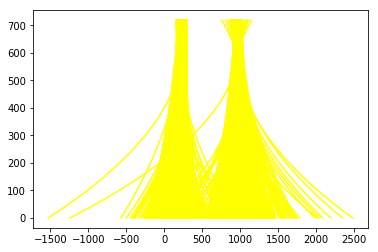

In [38]:
# process the video clip and save the result
output = 'project_output8.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(10,15)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [39]:
HTML("""
<video width="1200" height="750" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
'''
# I made the left fit and right fit polys global
# need to run this cell for every run of video
left_fit = None
right_fit = None
ploty = None
'''

In [ ]:
'''
challenge_output = 'challenge_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(15,30)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_output_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_output_clip.write_videofile(challenge_output, audio=False)
'''